In [1]:
import os
os.environ['GROQ_API_KEY'] = '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'

In [2]:
!pip install langchain-community==0.2.15 langchain-chroma==0.1.3 langchain-text-splitters==0.2.2 langchain-huggingface==0.0.3 langchain-groq==0.1.9 unstructured==0.15.0 unstructured[pdf]==0.15.0 nltk==3.8.1

In [4]:
import bs4
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
# from langchain_community.document_loaders import PyPDFLoader

In [5]:
embeddings_model = HuggingFaceEmbeddings()

sentence_list = ["Xin chào", "Hello", "Con chó", "Biển Vũng Tàu", "Con mèo", "Miami Beach"]
embeddings = embeddings_model.embed_documents(sentence_list)

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [10]:
len(embeddings[1])

768

In [11]:
import math

def cosine_similarity(v1, v2):
  """
  Tính toán độ tương đồng cosin giữa hai vector.

  Args:
      v1 (list): Vector thứ nhất.
      v2 (list): Vector thứ hai.

  Returns:
      float: Độ tương đồng cosin giữa hai vector.
  """

  # Tính tích vô hướng của hai vector.
  dot_product = sum(a * b for a, b in zip(v1, v2))

  # Tính độ dài của mỗi vector.
  v1_length = math.sqrt(sum(a ** 2 for a in v1))
  v2_length = math.sqrt(sum(a ** 2 for a in v2))

  # Tránh trường hợp chia cho 0.
  if v1_length == 0 or v2_length == 0:
    return 0

  # Tính độ tương đồng cosin.
  similarity = dot_product / (v1_length * v2_length)

  return similarity


In [12]:
# So sánh chó và mèo
cosine_similarity(embeddings[2], embeddings[4])

0.5679544517552502

In [13]:
# So sánh chó và biển vũng tàu
cosine_similarity(embeddings[2], embeddings[3])

0.4646082000680415

In [14]:
cosine_similarity(embeddings[3], embeddings[-1])

0.13270004195791785

In [15]:
len(embeddings[0])

768

# Quan Sát Trong Không Gian 2 Chiều

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


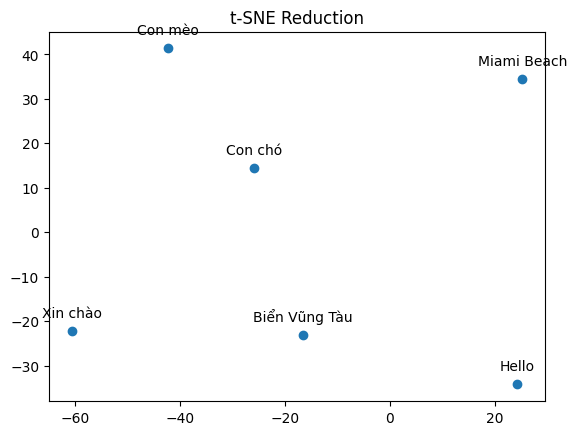

In [16]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming `embeddings` is your dataset and `sentence_list` contains labels
tsne = TSNE(n_components=2, perplexity=3, n_iter=1000)
embeddings_2d_tsne = tsne.fit_transform(np.array(embeddings))

# Create the scatter plot first
plt.scatter(embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1])
plt.title('t-SNE Reduction')

# Then annotate each point with its label
for i, label in enumerate(sentence_list):
    plt.annotate(label,
                 (embeddings_2d_tsne[i, 0], embeddings_2d_tsne[i, 1]),
                 textcoords="offset points",  # how to position the text
                 xytext=(0,10),  # distance from text to points (x,y)
                 ha='center')  # horizontal alignment can be left, right or center

# Finally, show the plot
plt.show()


# Thực Hành: Mini RAG

In [17]:
rag_sentence = [
    'Tổng thống Donald Trump trở thành ứng cử viên số một của Đảng Cộng Hoà trong cuộc tranh cử năm 2024.',
    'Manchester United trải qua một mùa giải được coi là tạm chấp nhận được, họ không thể đòi hỏi gì hơn với những gì họ đang có hiện tại.',
    'Tlinh trở thành ca sĩ trẻ nổi bật nhất của năm 2023 với những giải thưởng danh giá, đặc biệt là nghệ sĩ được yêu thích nhất trên Spotify tại Việt Nam.',
    'Apple cho thấy sự vượt trội trong phát triển sản phẩm nhờ luôn mang lại được những trải nghiệm tuyệt vời cho người dùng.',
    'Tết năm 2024 chứng kiến cảnh nhiều nhà vắng mặt những thành viên yêu quý vì chi phí quá cao và tình hình kinh tế suy sụp.'
]

rag_embed = embeddings_model.embed_documents(rag_sentence)

In [18]:
question = 'Vì sao Samsung vượt trội?'
question_emb = embeddings_model.embed_query(question)

In [19]:
def find_most_similar_sentence(question_emb, rag_sentence, rag_embed):
  # return the sentence from rag_setence with the most similarity to question_emb
  most_sim = 0
  best_sentence = None
  for i, sentence in enumerate(rag_sentence):
    similarity = cosine_similarity(question_emb, rag_embed[i])
    if most_sim < similarity:
      most_sim = similarity
      best_sentence = sentence

  if most_sim < 0.85:
    return "Tôi không biết"
  else:
    return best_sentence

In [21]:
best = find_most_similar_sentence(question_emb, rag_sentence, rag_embed)
print(best)

Tôi không biết


In [22]:
cosine_similarity(question_emb, rag_embed[3])

0.2413407375679427

In [26]:
!pip install transformers

In [31]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

sentences = ['search_query: What is TSNE?', 'search_query: Who is Laurens van der Maaten?']

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('nomic-ai/nomic-embed-text-v1.5', trust_remote_code=True, safe_serialization=True)
model.eval()

encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

matryoshka_dim = 512

with torch.no_grad():
    model_output = model(**encoded_input)

embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
embeddings = F.layer_norm(embeddings, normalized_shape=(embeddings.shape[1],))
embeddings = embeddings[:, :matryoshka_dim]
embeddings = F.normalize(embeddings, p=2, dim=1)
print(embeddings)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/547M [00:00<?, ?B/s]

tensor([[-0.0052,  0.0651, -0.2156,  ..., -0.0323, -0.0637, -0.0287],
        [-0.0083,  0.0051, -0.2218,  ...,  0.0353, -0.0687,  0.0541]])


In [33]:
print(embeddings.shape)

torch.Size([2, 512])
